In [1]:
import os
import json
import pprint
import tensorflow as tf
import matplotlib.pyplot as plt
 
 
# d'après le site qui héberge le site Web du jeu de données Coco 2017:
# les images sont au format JPG et possèdent les méta-données suivantes:
 
 
# id: int,
# image_id: int,
# category_id: int,
# segmentation: RLE or [polygon], object segmentation mask
# bbox: [x,y,width,height], object bounding box coordinates
# area: float, area of the bounding box
# iscrowd: 0 or 1, is single object or a collection
 
root_dir = "./s_datasets"
os.makedirs("./s_datasets",exist_ok=True)
 
tfrecords_dir = "s_tfrecords"
images_dir = os.path.join(root_dir, "val2017")
annotations_dir = os.path.join(root_dir, "annotations")
os.makedirs(annotations_dir,exist_ok=True)
os.makedirs(images_dir,exist_ok=True)
annotation_file = os.path.join(annotations_dir, "instances_val2017.json")

 
images_url = "http://images.cocodataset.org/zips/val2017.zip"
annotations_url = (
   "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
)
 
# télécharge les image et détruit le zip temporaire

image_zip = tf.keras.utils.get_file(
    "images.zip",
    cache_dir=os.path.abspath("."),
    origin=images_url,
    extract=True,
)


 

815595520/815585330 [==============================] - 539s 1us/step


In [ ]:
# On vérifie que les fichiers aient bien été extraits
!ls s_datasets

annotations  val2017


In [2]:
 
# télécharge les annotations et détruit le zip temporaire
if os.path.exists(annotations_dir):
   annotation_zip = tf.keras.utils.get_file(
       "captions.zip",
       cache_dir=os.path.abspath("."),
       origin=annotations_url,
       extract=True,
   )
   #os.remove(annotation_zip)
 
print("Succès: Le jeu de données COCO  a été téléchargé.")

252919808/252907541 [==============================] - 16s 0us/step
Succès: Le jeu de données COCO  a été téléchargé.


In [3]:
!cp -r  datasets/annotations/ ./s_datasets/
!cp -r  datasets/val2017/ ./s_datasets/

In [4]:
!ls ./s_datasets/annotations/

captions_train2017.json   instances_val2017.json
captions_val2017.json	  person_keypoints_train2017.json
instances_train2017.json  person_keypoints_val2017.json


In [5]:
!ls ./s_datasets/val2017/

000000000139.jpg  000000147729.jpg  000000289594.jpg  000000435206.jpg
000000000285.jpg  000000147740.jpg  000000289659.jpg  000000435208.jpg
000000000632.jpg  000000147745.jpg  000000289702.jpg  000000435299.jpg
000000000724.jpg  000000148508.jpg  000000289741.jpg  000000435880.jpg
000000000776.jpg  000000148620.jpg  000000289938.jpg  000000436315.jpg
000000000785.jpg  000000148662.jpg  000000289960.jpg  000000436551.jpg
000000000802.jpg  000000148707.jpg  000000289992.jpg  000000436617.jpg
000000000872.jpg  000000148719.jpg  000000290081.jpg  000000436738.jpg
000000000885.jpg  000000148730.jpg  000000290163.jpg  000000436883.jpg
000000001000.jpg  000000148739.jpg  000000290179.jpg  000000437110.jpg
000000001268.jpg  000000148783.jpg  000000290248.jpg  000000437205.jpg
000000001296.jpg  000000148957.jpg  000000290293.jpg  000000437239.jpg
000000001353.jpg  000000148999.jpg  000000290592.jpg  000000437331.jpg
000000001425.jpg  000000149222.jpg  000000290619.jpg  000000437351.jpg
000000

In [6]:
with open(annotation_file, "r") as f:
   annotations = json.load(f)["annotations"]
 
print(f"# images avec annotations: {len(annotations)}")
 
# exemple d’observation
pprint.pprint(annotations[10])

# images avec annotations: 36781
{'area': 4290.290900000001,
 'bbox': [297.73, 252.34, 60.21, 108.45],
 'category_id': 18,
 'id': 8032,
 'image_id': 329219,
 'iscrowd': 0,
 'segmentation': [[304.09,
                   266.18,
                   308.95,
                   263.56,
                   313.06,
                   262.81,
                   318.3,
                   262.81,
                   322.04,
                   262.81,
                   336.25,
                   264.68,
                   338.87,
                   264.68,
                   344.85,
                   259.07,
                   353.83,
                   252.34,
                   352.7,
                   258.32,
                   344.1,
                   269.17,
                   352.33,
                   274.4,
                   357.94,
                   281.88,
                   357.94,
                   293.1,
                   356.07,
                   300.58,
                   356.

In [8]:
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import glob2
import os
from matplotlib import pyplot as plt
import PIL

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))): # if value ist tensor
        value = value.numpy() # get value of tensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a floast_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[int(value)]))

def serialize_array(array):
    """serialize a matrix/image to binary object"""
    array = tf.io.serialize_tensor(array)
    return array

def parse_single_image(image, label):
    """parse a single example from image information and label information"""
    # define the dictionary -- the structure -- of our single example
    data = {
        'x': _int64_feature(label['bbox'][0]),
        'y': _int64_feature(label['bbox'][1]),
        'w': _int64_feature(label['bbox'][2]),
        'h': _int64_feature(label['bbox'][3]),

        'height'    : _int64_feature(image.shape[0]),
        'width'     : _int64_feature(image.shape[1]),
        'depth'     : _int64_feature(image.shape[2]),
        'raw_image' : _bytes_feature(serialize_array(image)),
        'label'     : _int64_feature(label['category_id'])
    }
    # create an Example, wrapping the single features
    out = tf.train.Example(features=tf.train.Features(feature=data))
    return out






In [9]:
!ls /content/s_datasets/val2017/000000289343.jpg

/content/s_datasets/val2017/000000289343.jpg


In [10]:
annotations[0]

{'area': 702.1057499999998,
 'bbox': [473.07, 395.93, 38.65, 28.67],
 'category_id': 18,
 'id': 1768,
 'image_id': 289343,
 'iscrowd': 0,
 'segmentation': [[510.66,
   423.01,
   511.72,
   420.03,
   510.45,
   416.0,
   510.34,
   413.02,
   510.77,
   410.26,
   510.77,
   407.5,
   510.34,
   405.16,
   511.51,
   402.83,
   511.41,
   400.49,
   510.24,
   398.16,
   509.39,
   397.31,
   504.61,
   399.22,
   502.17,
   399.64,
   500.89,
   401.66,
   500.47,
   402.08,
   499.09,
   401.87,
   495.79,
   401.98,
   490.59,
   401.77,
   488.79,
   401.77,
   485.39,
   398.58,
   483.9,
   397.31,
   481.56,
   396.35,
   478.48,
   395.93,
   476.68,
   396.03,
   475.4,
   396.77,
   473.92,
   398.79,
   473.28,
   399.96,
   473.49,
   401.87,
   474.56,
   403.47,
   473.07,
   405.59,
   473.39,
   407.71,
   476.68,
   409.41,
   479.23,
   409.73,
   481.56,
   410.69,
   480.4,
   411.85,
   481.35,
   414.93,
   479.86,
   418.65,
   477.32,
   420.03,
   476.04,
   4

In [11]:
images_dir = "/content/s_datasets/val2017/"

In [12]:
def write_images_to_tfr_short(input_json, filename, output_dir = "./TF"):
    
    #images = input_json["jpg"].values
    #labels = input_json["category_id"]

    # define the output (=tfrecord file)
    # we create the folder if needed
    os.makedirs(output_dir, exist_ok=True)
    filename = f"{output_dir}/{filename}.tfrecord"
    
    # create a writer that'll store our data to disk (open a tf.writer)
    writer = tf.io.TFRecordWriter(filename)     
    count = 0

    # iterate over images element
    for index in tqdm(range(len(input_json))[:10]):
        try:
            #get the data we want to write
            image = os.path.join(images_dir,str(input_json[index]["image_id"]).zfill(12) + ".jpg")
            current_image = plt.imread(image)
            current_label = input_json[index]['category_id']

            plt.imshow(current_image)
            plt.show()

            current_label = input_json[index]
            #
            out = parse_single_image(image=current_image, label=current_label)
            writer.write(out.SerializeToString())
            count += 1
        except (PIL.UnidentifiedImageError,FileNotFoundError) as e:
            print(e)
            pass

    # closethe tf.writer
    writer.close()
    # outputs how many elements were added to the TFRecord file
    print(f"Wrote {count} elements to TFRecord")
    return count



  0%|          | 0/10 [00:00<?, ?it/s]

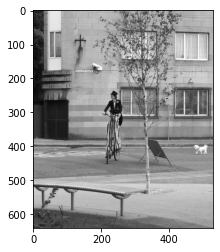

 10%|█         | 1/10 [00:00<00:03,  2.57it/s]

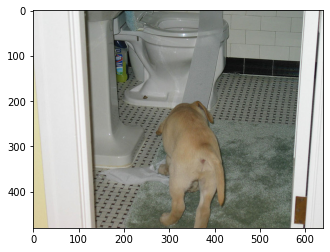

 20%|██        | 2/10 [00:00<00:02,  3.43it/s]

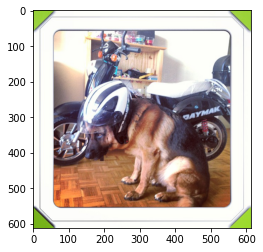

 30%|███       | 3/10 [00:00<00:01,  3.83it/s]

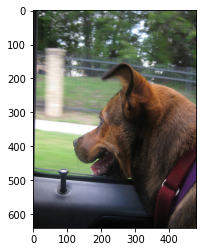

 40%|████      | 4/10 [00:01<00:01,  4.10it/s]

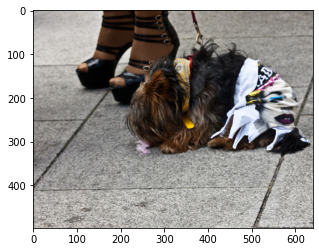

 50%|█████     | 5/10 [00:01<00:01,  4.15it/s]

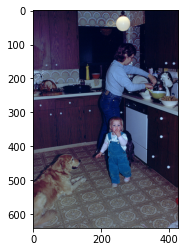

 60%|██████    | 6/10 [00:01<00:00,  4.35it/s]

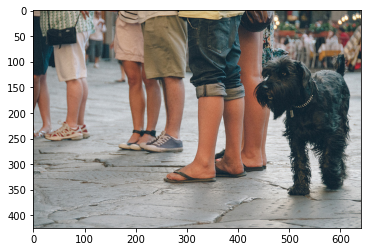

 70%|███████   | 7/10 [00:01<00:00,  4.23it/s]

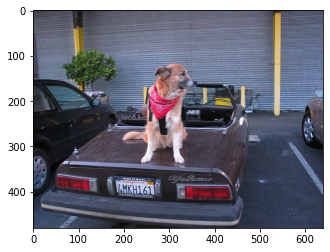

 80%|████████  | 8/10 [00:02<00:00,  4.14it/s]

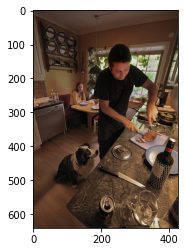

 90%|█████████ | 9/10 [00:02<00:00,  4.31it/s]

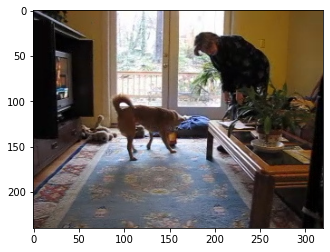

100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

Wrote 10 elements to TFRecord


10

In [13]:
write_images_to_tfr_short(input_json=annotations, filename="trucmuche.tfrecord", output_dir = "./TF")

In [14]:
def parse_tfr_element_for_viz(element):
    # on récupère les éléments d'intérêts en matchant bien leur type
    # les données sont de sentiers (pour la plupart)
    # sauf pour le nom de l'image
    data = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width':tf.io.FixedLenFeature([], tf.int64),
        'depth':tf.io.FixedLenFeature([], tf.int64),
        'raw_image' : tf.io.FixedLenFeature([], tf.string),
        'label':tf.io.FixedLenFeature([], tf.int64),
        'x':tf.io.FixedLenFeature([], tf.int64),
        'y':tf.io.FixedLenFeature([], tf.int64),
        'w':tf.io.FixedLenFeature([], tf.int64),
        'h':tf.io.FixedLenFeature([], tf.int64)
    }

    # on parse les éléments grâce au schéma de données défini ci-dessus
    # on analyse un élément à la fois
    content = tf.io.parse_single_example(element, data)

    # on récupère les informations de taille,largeur,profondeur et la classe associée 
    height = content['height']
    width = content['width']
    depth = content['depth']
    label = content['label']
    print(height, width,depth)

    # on récupère également les informations liées au cadre de détection (bounding box)
    x = content['x']
    y = content['y']
    w = content['w']
    h = content['h']

    # l'image quant à elle est stockée 
    # sous format binaire)
    raw_image = content['raw_image']
  
  
    # On transforme l' image (objet binaire)
    # on la redimensionne alors grâce aux informations:
    # hauteur largeur et profondeur 
    feature = tf.io.parse_tensor(raw_image, out_type=tf.uint8)
    feature = tf.reshape(feature, shape=[height, width, depth])
    print(feature.shape)
    plt.imshow(feature)
    plt.show()
    return (feature, label)

In [15]:
# Load the TFRecords and create tf.data.Dataset
def load_dataset(filenames):
    #dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=16) 
    dataset = dataset.map(parse_tfr_element_for_viz, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset